In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.svm import SVC
import scipy.fft
from scipy import stats
from scipy.stats import norm
import pickle
import matplotlib.pyplot as plt
import numpy as np
import itertools

ModuleNotFoundError: No module named 'scipy.stats.kurtosis'

In [4]:
d = pd.read_pickle('Data/DataFrame__sensori_rilevazioni_granulare_acc_normalizzate.pkl') 
data = pd.DataFrame(d)

In [9]:
window = 60
fs = 100
shift = 2
minutes = 50
car = 1
camion = 2

In [37]:
def label_creation(row_label, vehicle_type):
    return sum(row_label==vehicle_type)/10
def feature_extraction(data):
    features = []
    features.append(data.mean())
    features.append(data.median())
    features.append(data.std())
    features.append(data.min())
    features.append(data.max())
    features.append(data.abs().std())
    features.append(data.abs().min())
    features.append(data.abs().max())
    features.append(stats.kurtosis(data))
    features.append(stats.skew(data))
    features.append(sum(data.abs()))
    features.append(sum(data**2))
    #features.append(data)
    return features

In [38]:
windows = 0
dataset = []
label_car = []
label_camion = []
for index in np.arange(0,minutes*60*fs,shift*fs):
    if sum(data["rilevazione"][index:(index+window*fs)] == "NaN")<1:
        dataset_row = []
        for sens in data.keys():
            if "10" in sens and "xyz" not in sens:
                features = feature_extraction(data[sens][index:(index+window*fs)])  
                dataset_row.append(features)
        dataset_row = list(itertools.chain.from_iterable(dataset_row))
        y_car = label_creation(data["rilevazione"][index:(index+window*fs)], car)
        y_camion = label_creation(data["rilevazione"][index:(index+window*fs)], camion)
        label_car.append(y_car)
        label_camion.append(y_camion)
        dataset.append(dataset_row)

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

In [44]:
X_60 = dataset
y_car_60 = label_car
y_camion_60 = label_camion
X_car_60_50 = SelectKBest(f_regression, k=50).fit_transform(X_60, y_car_60)
X_camion_60_50 = SelectKBest(f_regression, k=50).fit_transform(X_60, y_camion_60)

In [45]:
X_train_car_60_50, X_test_car_60_50, y_train_car_60_50, y_test_car_60_50 = train_test_split(X_car_60_50, y_car_60)
X_train_camion_60_50, X_test_camion_60_50, y_train_camion_60_50, y_test_camion_60_50 = train_test_split(X_camion_60_50, y_camion_60)

In [46]:
def graf_car(y_p_car, y_car_pip, s):
    car = pd.DataFrame(data=y_p_car, columns=['y_predicted'])
    df_car = pd.DataFrame(data=y_car_pip, columns=['y_true'])
    df_car = pd.concat([car,df_car], axis=1)

    
    title = "CAR "+s+" label/prediction"
    plt.title(title)
    sns.scatterplot(data=df_car,x='y_predicted', y='y_true')
    plt.show()

MSE_car_pip_svr_60_05: 0.8691091323914786
MAE_car_pip_svr_60_05: 0.6321401054348416
R2_car_score_svr_60_05: 0.9183898175330394
MSPE_car_pip_svr_60_05: 13.509123573925738
MAPE_car_pip_svr_60_05: 9.82576121005152


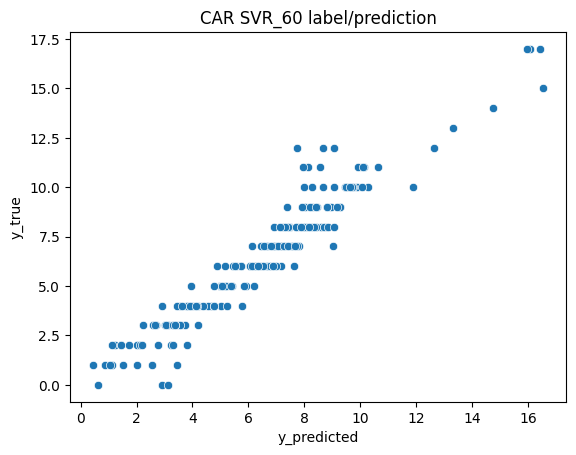

In [47]:
steps_svr = [
    ( 'scaler', StandardScaler() ),
    ('svr', SVR(kernel = 'rbf',epsilon=0.1, C=10))]


pipeline_svr_car = Pipeline(steps_svr)
pipeline_svr_car.fit(X_train_car_60_50,y_train_car_60_50)
y_p_car_svr_60_50 = pipeline_svr_car.predict(X_test_car_60_50)
y_test_car_60_50

### METRICHE MISURA ACCURATEZZA PER CAR
mse_car_pip_svr_60 = mean_squared_error(y_test_car_60_50, y_p_car_svr_60_50)
print("MSE_car_pip_svr_60_05:", mse_car_pip_svr_60)
mae_car_pip_svr_60 = mean_absolute_error(y_test_car_60_50, y_p_car_svr_60_50)
print("MAE_car_pip_svr_60_05:", mae_car_pip_svr_60)
r2_car_score_svr_60= r2_score(y_test_car_60_50, y_p_car_svr_60_50)
print("R2_car_score_svr_60_05:", r2_car_score_svr_60)

mspe_car_pip_svr_60 = (mse_car_pip_svr_60/np.mean(y_test_car_60_50))*100
print("MSPE_car_pip_svr_60_05:", mspe_car_pip_svr_60)
mape_car_pip_svr_60 = (mae_car_pip_svr_60/np.mean(y_test_car_60_50))*100
print("MAPE_car_pip_svr_60_05:", mape_car_pip_svr_60)

###STAMPA GRAFICI 

graf_car(y_p_car_svr_60_50, y_test_car_60_50, "SVR_60")

MSE_car_pip_svr_60_05: 0.13781131228031415
MAE_car_pip_svr_60_05: 0.2511302949649489
R2_car_score_svr_60_05: 0.9724151121657723
MSPE_car_pip_svr_60_05: 4.114072998956438
MAPE_car_pip_svr_60_05: 7.496977923218327


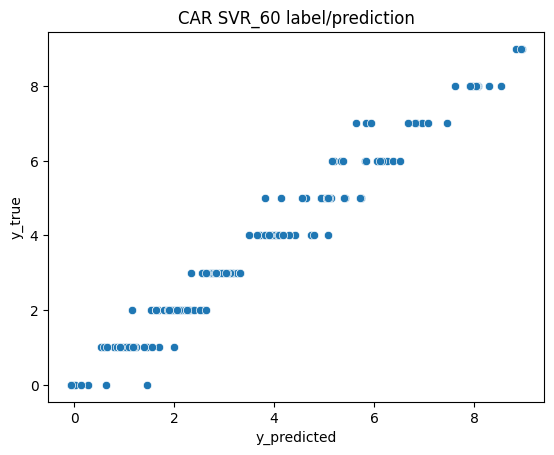

In [48]:
steps_svr = [
    ( 'scaler', StandardScaler() ),
    ('svr', SVR(kernel = 'rbf',epsilon=0.1, C=10))]


pipeline_svr_car = Pipeline(steps_svr)
pipeline_svr_car.fit(X_train_camion_60_50,y_train_camion_60_50)
y_p_camion_svr_60_50 = pipeline_svr_car.predict(X_test_camion_60_50)
y_test_camion_60_50

### METRICHE MISURA ACCURATEZZA PER CAR
mse_car_pip_svr_60 = mean_squared_error(y_test_camion_60_50, y_p_camion_svr_60_50)
print("MSE_car_pip_svr_60_05:", mse_car_pip_svr_60)
mae_car_pip_svr_60 = mean_absolute_error(y_test_camion_60_50, y_p_camion_svr_60_50)
print("MAE_car_pip_svr_60_05:", mae_car_pip_svr_60)
r2_car_score_svr_60= r2_score(y_test_camion_60_50, y_p_camion_svr_60_50)
print("R2_car_score_svr_60_05:", r2_car_score_svr_60)

mspe_car_pip_svr_60 = (mse_car_pip_svr_60/np.mean(y_test_camion_60_50))*100
print("MSPE_car_pip_svr_60_05:", mspe_car_pip_svr_60)
mape_car_pip_svr_60 = (mae_car_pip_svr_60/np.mean(y_test_camion_60_50))*100
print("MAPE_car_pip_svr_60_05:", mape_car_pip_svr_60)

###STAMPA GRAFICI 

graf_car(y_p_camion_svr_60_50, y_test_camion_60_50, "SVR_60")